# **TPS - Sep 2021**

## **Simple Baseline Using Pycaret (AutoML)**

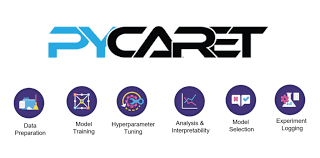

<h4> PyCaret is an open source, low-code machine learning library in Python that allows you to go from preparing your data to deploying your model within minutes in your choice of notebook environment.</h4>

### [Click Here](https://pycaret.org/) to visit pycaret.org

# **Install Pycaret, Import Library**

In [ ]:
!pip install pycaret

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *

# **Load Data**

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')

all_data = pd.concat([train, test])

In [ ]:
all_data2 = all_data.drop(columns = 'id')
all_data2

In [ ]:
all_data2['n_missing'] = all_data2[all_data2.columns[1:-1]].isna().sum(axis = 1)
all_data2['std'] = all_data2[all_data2.columns[1:-1]].std(axis = 1)
all_data2['min'] = all_data2[all_data2.columns[1:-1]].min(axis = 1)

# **Handle missing values**

*   We can use mean values to handle missing values.
*   Or, we can predict missing values with clean data.
*   In pycaret, we can use imputation function(numeric_imputation) :)



### **Distribution of Missing values**

In [ ]:
# Distribution

plt.figure(figsize = (12, 6))
missing_values = all_data2.isnull().sum()[:-1]
sns.histplot(missing_values, color='violet');
plt.show()

print('\n')
print('-------- Distribution of Missing values --------')
print('Min:', missing_values.min())
print('Max:', missing_values.max())
print('Mean:', missing_values.mean())
print('------------------------------------------------')

# **Modeling**

## Stacking Ensemble
* LightGBM
* Catboost
* Xgboost

In [ ]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):]
test2.drop(columns = 'claim', inplace = True)

In [ ]:
from sklearn.metrics import log_loss

def pycaret_model(train, target, test, fold):
    
    print('Setup Your Data....')
    setup(data=train,
        target=target,
        normalize = True,
        silent= True,
        use_gpu=True,
        session_id = 42)
    
    add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target='pred_proba')
    
    print('Creating Models....')
    
    model_list = []
    lgbm = create_model(estimator = 'lightgbm', fold = fold)
    xgb = create_model(estimator = 'xgboost', fold = fold)
    cat = create_model(estimator = 'catboost', fold = fold)
    
    model_list.append(lgbm)
    model_list.append(xgb)

    print('Finallizing Models....')
    stack = stack_models(estimator_list = model_list, meta_model = cat, fold = fold)
    final_model = finalize_model(stack)
    print('Done...!!!')

    prep_pipe = get_config('prep_pipe')
    prep_pipe.steps.append(['trained_model', stack])
    pred = prep_pipe.predict_proba(test)

    return pred

In [ ]:
result = pycaret_model(train2, 'claim', test2, 5)
result

In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv')
sub

In [ ]:
sub['claim'] = result[:, 1]
sub.to_csv('sub.csv', index = 0)